# Moondream LLM

VLMs such as [moondream](https://huggingface.co/vikhyatk/moondream2) allow us to draw bounding boxes around objects in images.

The installation (on Windows) is a bit tricky:
* Download vips-dev-w64-all-8.16.1.zip from [here](https://github.com/libvips/build-win64-mxe/releases/tag/v8.16.1), unzip it, and add its subfolder `bin` to the PATH environment variable.
* `pip install einops pyvips`

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from PIL import Image
from image_utilities import numpy_to_bytestream, extract_json
from tqdm import tqdm
import stackview
from skimage.io import imread
import numpy as np


model = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2",
    revision="2025-01-09",
    trust_remote_code=True,
    # Comment to run on CPU. To use the GPU, you need about 5 GB of GPU Memory.
    device_map={"": "cuda"}
)

## Example data
We load an example RGB image first.

StackViewNDArray([[[176, 178, 179],
                   [175, 178, 178],
                   [177, 177, 180],
                   ...,
                   [182, 186, 188],
                   [185, 188, 191],
                   [191, 194, 197]],

                  [[178, 180, 181],
                   [178, 179, 181],
                   [178, 180, 181],
                   ...,
                   [185, 189, 192],
                   [187, 191, 192],
                   [191, 195, 198]],

                  [[181, 183, 185],
                   [180, 182, 183],
                   [180, 181, 183],
                   ...,
                   [190, 193, 196],
                   [189, 193, 196],
                   [192, 195, 198]],

                  ...,

                  [[125,  91,  66],
                   [124,  90,  65],
                   [123,  89,  65],
                   ...,
                   [137,  92,  64],
                   [136,  91,  62],
                   [135,  89,  61]],

                  [[122,  88,  64],
                   [121,  87,  63],
                   [121,  87,  63],
                   ...,
                   [142,  96,  68],
                   [142,  96,  68],
                   [139,  94,  65]],

                  [[120,  86,  62],
                   [120,  86,  60],
                   [119,  85,  61],
                   ...,
                   [144,  99,  70],
                   [144,  99,  70],
                   [142,  97,  68]]], dtype=uint8)
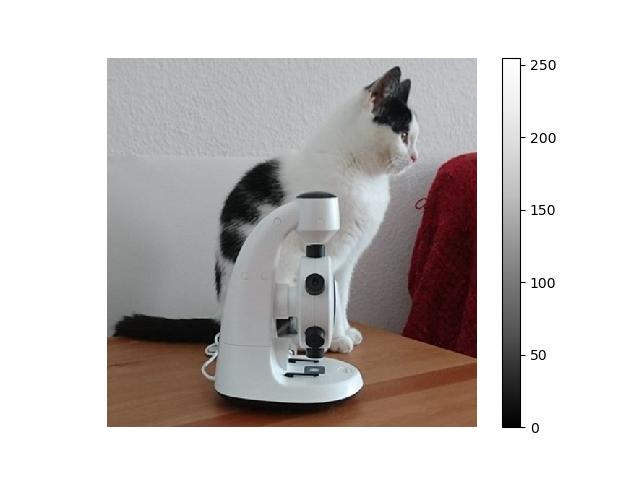
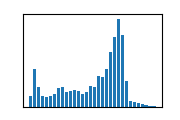

In [7]:
image = imread("data/real_cat.png")

# Display the image
stackview.insight(image)

This image needs to be converted to a Pillow Image, before we can encode it.

In [8]:
pil_image = Image.fromarray(image)

encoded_image = model.encode_image(pil_image)

## Pointing
We can then ask for coordinates in the image where given objects are.

In [9]:
prompt = "Mark the animals"

points = model.point(encoded_image, prompt)["points"]

print(f"Found {len(points)} bright spot(s)")
points

Found 1 bright spot(s)


[{'x': 0.6943359375, 'y': 0.427734375}]

StackViewNDArray([[[176, 178, 179],
                   [175, 178, 178],
                   [177, 177, 180],
                   ...,
                   [182, 186, 188],
                   [185, 188, 191],
                   [191, 194, 197]],

                  [[178, 180, 181],
                   [178, 179, 181],
                   [178, 180, 181],
                   ...,
                   [185, 189, 192],
                   [187, 191, 192],
                   [191, 195, 198]],

                  [[181, 183, 185],
                   [180, 182, 183],
                   [180, 181, 183],
                   ...,
                   [190, 193, 196],
                   [189, 193, 196],
                   [192, 195, 198]],

                  ...,

                  [[125,  91,  66],
                   [124,  90,  65],
                   [123,  89,  65],
                   ...,
                   [137,  92,  64],
                   [136,  91,  62],
                   [135,  89,  61]],

                  [[122,  88,  64],
                   [121,  87,  63],
                   [121,  87,  63],
                   ...,
                   [142,  96,  68],
                   [142,  96,  68],
                   [139,  94,  65]],

                  [[120,  86,  62],
                   [120,  86,  60],
                   [119,  85,  61],
                   ...,
                   [144,  99,  70],
                   [144,  99,  70],
                   [142,  97,  68]]], dtype=uint8)
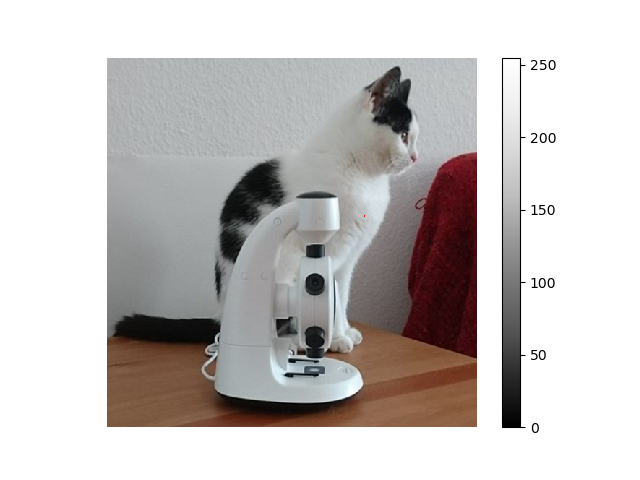
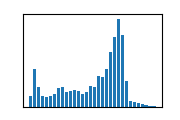

In [10]:
stackview.add_bounding_boxes(image, points)

## Bounding boxes
Better for visualization might be a bounding box surrounding the object of interest.

In [12]:
bb = model.detect(encoded_image, prompt)["objects"]
bb

[{'x_min': 0.39208984375,
  'y_min': 0.041015625,
  'x_max': 0.91650390625,
  'y_max': 0.796875}]

StackViewNDArray([[[176, 178, 179],
                   [175, 178, 178],
                   [177, 177, 180],
                   ...,
                   [182, 186, 188],
                   [185, 188, 191],
                   [191, 194, 197]],

                  [[178, 180, 181],
                   [178, 179, 181],
                   [178, 180, 181],
                   ...,
                   [185, 189, 192],
                   [187, 191, 192],
                   [191, 195, 198]],

                  [[181, 183, 185],
                   [180, 182, 183],
                   [180, 181, 183],
                   ...,
                   [190, 193, 196],
                   [189, 193, 196],
                   [192, 195, 198]],

                  ...,

                  [[125,  91,  66],
                   [124,  90,  65],
                   [123,  89,  65],
                   ...,
                   [137,  92,  64],
                   [136,  91,  62],
                   [135,  89,  61]],

                  [[122,  88,  64],
                   [121,  87,  63],
                   [121,  87,  63],
                   ...,
                   [142,  96,  68],
                   [142,  96,  68],
                   [139,  94,  65]],

                  [[120,  86,  62],
                   [120,  86,  60],
                   [119,  85,  61],
                   ...,
                   [144,  99,  70],
                   [144,  99,  70],
                   [142,  97,  68]]], dtype=uint8)
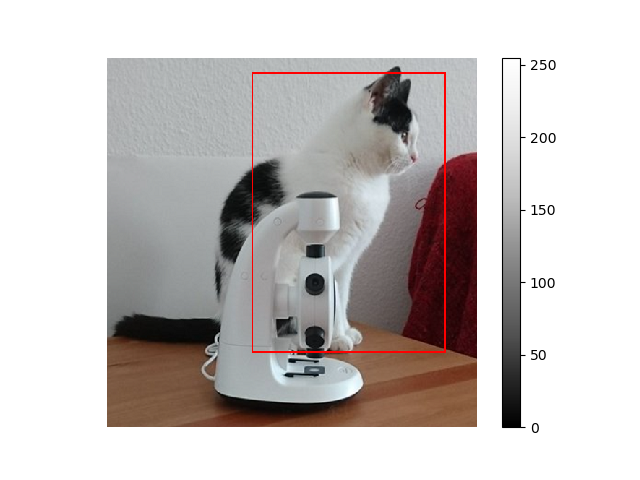
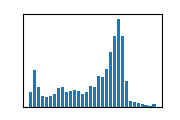

In [13]:
stackview_bb = [{
    "x": b["x_min"],   
    "y": b["y_min"],   
    "width": b["x_max"] - b["x_min"],
    "height": b["y_max"] - b["y_min"]
    } for b in bb
]

image_with_bb = stackview.add_bounding_boxes(image, stackview_bb)

image_with_bb

## Exercise
Use different prompts for drawing bounding boxes on this image. Consider asking for specific devices, and also ask for drawing bounding boxes around all objects in the image. What other objects are detected?